In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
# Stage a: Load a pre-trained CNN model trained on a large dataset
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Stage b: Freeze parameters in the model’s lower convolutional layers
for layer in base_model.layers:
    layer.trainable = False

In [3]:
# Stage c: Add a custom classifier with several layers of trainable parameters to the model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)  # Assuming 10 classes

In [4]:
# Define the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Stage d: Train classifier layers on training data available for the task
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [5]:
# Prepare data generators
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Replace 'path_to_train' and 'path_to_validation' with actual paths
train_generator = train_datagen.flow_from_directory('./train',
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='categorical')
validation_generator = validation_datagen.flow_from_directory('./validation',
                                                              target_size=(224, 224),
                                                              batch_size=32,
                                                              class_mode='categorical')

Found 4000 images belonging to 4 classes.
Found 800 images belonging to 4 classes.


In [ ]:
# Train the model
history = model.fit(train_generator,
                    epochs=10,
                    validation_data=validation_generator)

# Stage e: Fine-tune hyperparameters and unfreeze more layers as needed
# Unfreeze the last few layers of the base model
for layer in base_model.layers[-20:]:
    layer.trainable = True

/Users/amuzz/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.9371 - loss: 0.1738

/Users/amuzz/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 38s 291ms/step - accuracy: 0.9375 - loss: 0.1729 - val_accuracy: 1.0000 - val_loss: 4.6525e-04
Epoch 2/10
120/125 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step - accuracy: 0.9855 - loss: 0.0555

In [7]:
# Re-compile the model with a lower learning rate
model.compile(optimizer=Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Continue training
history_fine = model.fit(train_generator,
                         epochs=5,
                         validation_data=validation_generator)

# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print(f'\nValidation Accuracy: {accuracy:.4f}')

Epoch 1/5
125/125 [==============================] - 111s 854ms/step - loss: 0.2823 - accuracy: 0.9710 - val_loss: 3.0938 - val_accuracy: 0.9350
Epoch 2/5
125/125 [==============================] - 113s 905ms/step - loss: 0.0671 - accuracy: 0.9908 - val_loss: 1.4168 - val_accuracy: 0.9513
Epoch 3/5
125/125 [==============================] - 113s 901ms/step - loss: 0.0149 - accuracy: 0.9967 - val_loss: 0.2974 - val_accuracy: 0.9950
Epoch 4/5
125/125 [==============================] - 113s 898ms/step - loss: 0.0272 - accuracy: 0.9950 - val_loss: 1.2579 - val_accuracy: 0.9737
Epoch 5/5
25/25 [==============================] - 13s 508ms/step - loss: 32.6440 - accuracy: 0.7275

Validation Accuracy: 0.7275


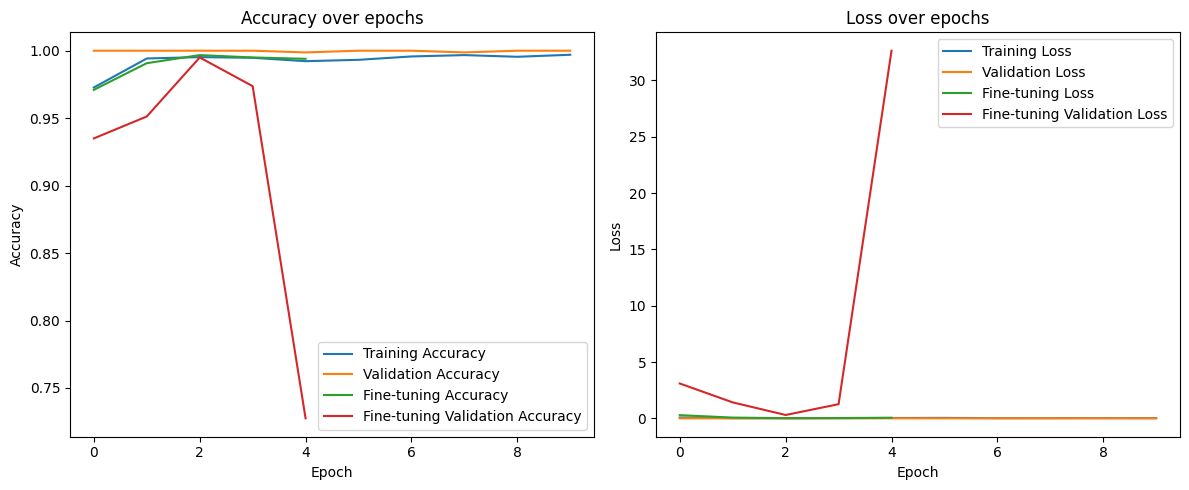

In [8]:
# Plot training and validation accuracy and loss
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_fine.history['accuracy'], label='Fine-tuning Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Fine-tuning Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history_fine.history['loss'], label='Fine-tuning Loss')
plt.plot(history_fine.history['val_loss'], label='Fine-tuning Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
model.save('transfer_learning.keras')

In [15]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Load and preprocess the image
test_image = "./validation/Tomato/1203.jpg"


img = image.load_img(test_image, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# Predict the class
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)

class_names = ['Capsicum', 'Carrot', 'Potato', 'Tomato']
print(f'Predicted class: {predicted_class}')
print(f'Predicted class name: {class_names[predicted_class[0]]}')

1/1 [==============================] - 0s 43ms/step
Predicted class: [3]
Predicted class name: Tomato
